# Direct Loss Estimation by NannyML

In [1]:
#Import cell 
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor  # optional, not needed if not using quantiles frp
from matplotlib import pyplot as plt
import ast
from lightgbm import LGBMRegressor




In [2]:
df_mp = pd.read_csv("materials_data_featurized.csv") # Load the dataset

In [3]:
#take care of the bulk and shear modulus columns
def extract_vrh(modulus):
    if pd.isnull(modulus):
        return np.nan
    if isinstance(modulus, dict):
        return modulus.get('vrh', np.nan)
    if isinstance(modulus, str):
        try:
            d = ast.literal_eval(modulus)
            return d.get('vrh', np.nan)
        except Exception:
            return np.nan
    return np.nan

df_mp["bulk_modulus_vrh"] = df_mp["bulk_modulus"].apply(extract_vrh)
df_mp["shear_modulus_vrh"] = df_mp["shear_modulus"].apply(extract_vrh)

In [4]:
# Exclude unwanted columns and keep only numeric features
excluded = [
    "material_id", "composition", "formula_pretty", "symmetry", "structure",
    "bulk_modulus", "shear_modulus", "band_gap"
]
X = df_mp.drop(excluded, axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

X = X.fillna(0) # Fill NaN values with 0

# Filter out band gaps that are zero or too small
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

# Reset index to keep alignment after filtering
df_mp = df_mp.reset_index(drop=True)
X = X.loc[df_mp.index].reset_index(drop=True)
y = y.reset_index(drop=True)

# Split into train (20%), test (20%), prod (60%)
n = len(df_mp)
df_train = df_mp.iloc[:int(n/5)]
df_test = df_mp.iloc[int(n/5):int(n/5*2)]
df_prod = df_mp.iloc[int(n/5*2):]

X_train = X.iloc[:int(n/5)]
X_test = X.iloc[int(n/5):int(n/5*2)]
X_prod = X.iloc[int(n/5*2):]

y_train = y.iloc[:int(n/5)]
y_test = y.iloc[int(n/5):int(n/5*2)]
y_prod = y.iloc[int(n/5*2):]

In [5]:
# Clean feature names: replace whitespace with underscores
X_train.columns = X_train.columns.str.replace(r"\s+", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"\s+", "_", regex=True)
X_prod.columns = X_prod.columns.str.replace(r"\s+", "_", regex=True)


In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=1).fit(X=X_train,y=y_train)

In [7]:
pred_test = pd.Series(model.predict(X_test), index=X_test.index).clip(0)
error_test = pred_test - y_test

In [8]:
print(error_test)

7193     0.993844
7194    -0.696583
7195    -0.841610
7196    -0.902624
7197     1.869529
           ...   
14381   -0.692709
14382    2.329751
14383   -2.615646
14384   -1.719666
14385    0.666549
Length: 7193, dtype: float64


In [12]:
# Add predicted values as a new column for error model
X_test_with_pred = X_test.copy()
X_test_with_pred["pred"] = pred_test

# Train the error model
model_abs_error = RandomForestRegressor()
model_abs_error.fit(X_test_with_pred, error_test.abs())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
pred_prod = pd.Series(model.predict(X_prod), index=X_prod.index).clip(0)
# Add predicted values as a new column with a string name
X_prod_with_pred = X_prod.copy()
X_prod_with_pred["pred"] = pred_prod

# Ensure all column names are strings
X_prod_with_pred.columns = X_prod_with_pred.columns.astype(str)

# Predict absolute error
pred_abs_error_prod = pd.Series(model_abs_error.predict(X_prod_with_pred), index=X_prod.index)

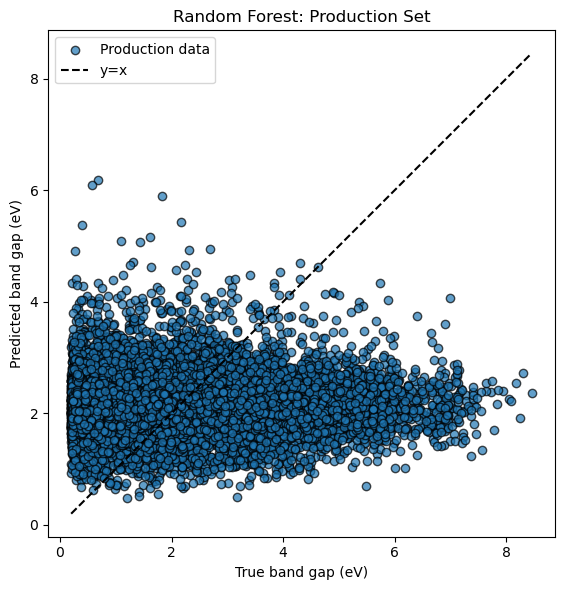

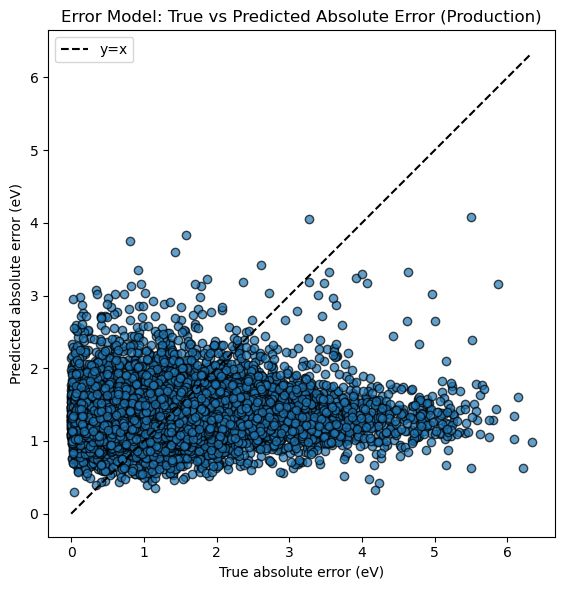

In [14]:
import matplotlib.pyplot as plt

# 1. Plot: Main model predictions vs true values (production set)
plt.figure(figsize=(6, 6))
plt.scatter(y_prod, pred_prod, alpha=0.7, edgecolor='k', label='Production data')
plt.plot([y_prod.min(), y_prod.max()], [y_prod.min(), y_prod.max()], 'k--', label='y=x')
plt.xlabel('True band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.title('Random Forest: Production Set')
plt.legend()
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Calculate true absolute errors on production set
true_abs_error_prod = (pred_prod - y_prod).abs()

# Plot: True vs Predicted absolute errors (production set)
plt.figure(figsize=(6, 6))
plt.scatter(true_abs_error_prod, pred_abs_error_prod, alpha=0.7, edgecolor='k')
plt.plot([0, max(true_abs_error_prod.max(), pred_abs_error_prod.max())],
         [0, max(true_abs_error_prod.max(), pred_abs_error_prod.max())], 'k--', label='y=x')
plt.xlabel('True absolute error (eV)')
plt.ylabel('Predicted absolute error (eV)')
plt.title('Error Model: True vs Predicted Absolute Error (Production)')
plt.legend()
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()